# RetailVision – U.S. Retail Sales Forecasting

In [13]:
# Import the libraries
!pip install prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

## 1. Data Acquisition and Loading

In [2]:
# Load dataset  and create a dataframes
df = pd.read_csv("../data/us_advance_retail_sales.csv")

# Ensure datetime format
df['observation_date'] = pd.to_datetime(df['observation_date'], format='%d/%m/%Y')
df = df.set_index('observation_date')

# Align to month start
df.index = df.index.to_period('M').to_timestamp()
df.index.freq = 'MS'


In [3]:
print("First ten rows of the Retail  dataset:")
df.head(10)

First ten rows of the Retail  dataset:


,Retail Sales
observation_date,
1992-01-01,142419
1992-02-01,142584
1992-03-01,142120
1992-04-01,143659
1992-05-01,144239
1992-06-01,145273
1992-07-01,146743
1992-08-01,146070
1992-09-01,147932


In [4]:
print("Dimensions of the data frame:", df.shape)

Dimensions of the data frame: (403, 1)


## 2. EDA with Visualizations

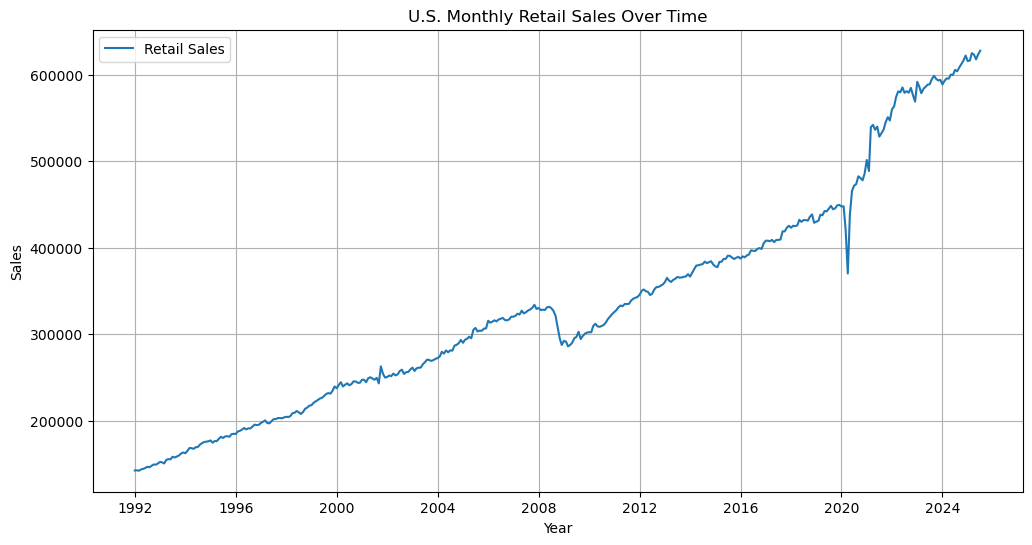

In [5]:
# Monthy Sales Over Time
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Retail Sales'], label='Retail Sales')
plt.title("U.S. Monthly Retail Sales Over Time")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.show()

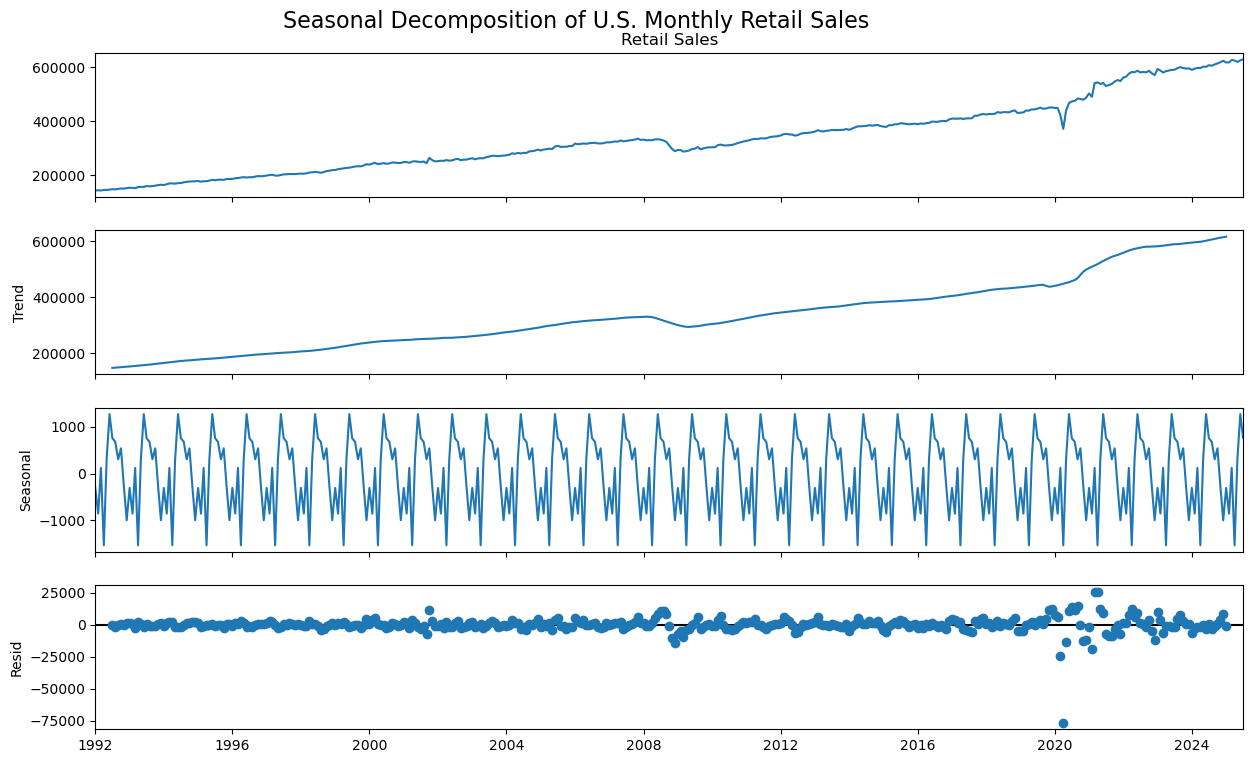

In [6]:
# Seasonal decomposition
decomposition = seasonal_decompose(df['Retail Sales'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(14, 8)
fig.suptitle("Seasonal Decomposition of U.S. Monthly Retail Sales", fontsize=16)
plt.show()

## 3. Model 1: Linear Regression

Linear Regression Performance:
MAE: 3443.757055257127
RMSE: 4101.816252038519


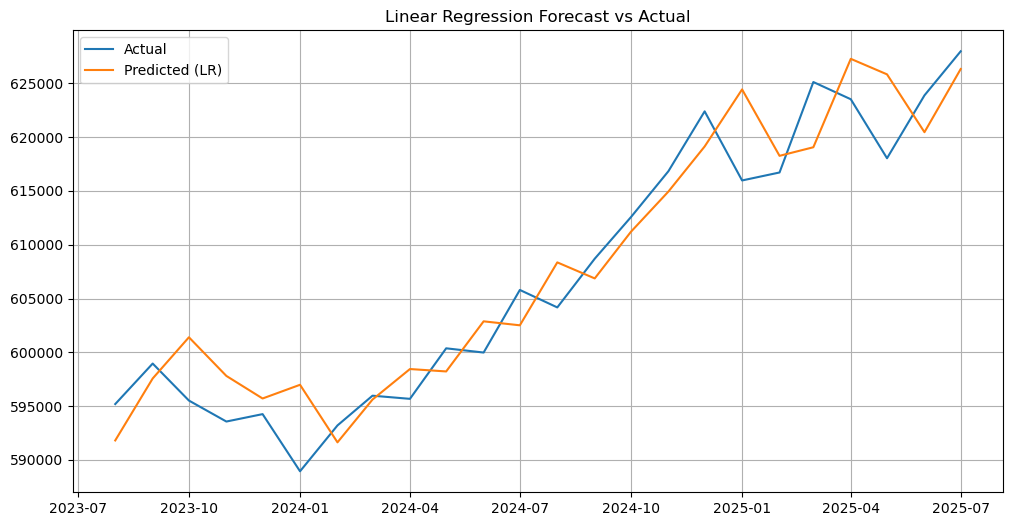

In [8]:
df_lr = df.copy()

# Create lag features for Linear Regression
df_lr['lag_1'] = df_lr['Retail Sales'].shift(1)
df_lr['lag_12'] = df_lr['Retail Sales'].shift(12)  # yearly seasonality

# Drop NaN rows caused by shifting
df_lr = df_lr.dropna()

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Evaluation
print("Linear Regression Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

plt.figure(figsize=(12,6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, y_pred_lr, label='Predicted (LR)')
plt.title("Linear Regression Forecast vs Actual")
plt.grid(True)
plt.legend()
plt.show()

## 5. Model 2: SARIMA

#### This uses a SARIMA model to forecast "Retail Sales" data. SARIMA stands for Seasonal Autoregressive Integrated Moving Average, and it's a powerful statistical model specifically designed for time series data with a seasonal component.

SARIMA Performance:
MAE: 4352.83606366153
RMSE: 5276.176071721282


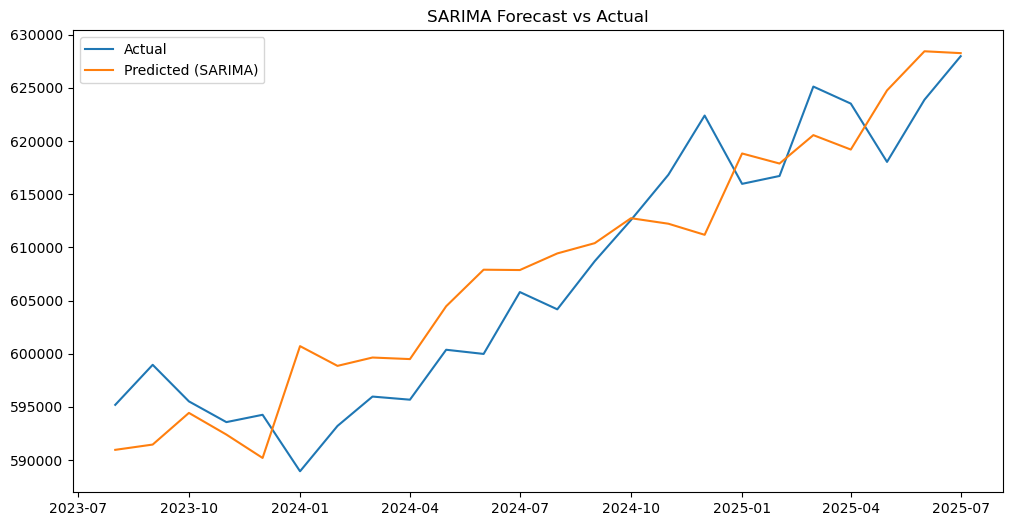

In [9]:
sarima_model = SARIMAX(train['Retail Sales'], 
                       order=(1,1,1), 
                       seasonal_order=(1,1,1,12)
                      )
sarima_fit = sarima_model.fit(disp=False)

start_index = len(train) # The index of the first row in the test set
end_index = len(df) - 1  # The index of the last row in the test set
y_pred_sarima = sarima_fit.predict(start=start_index, end=end_index)

# Evaluation
print("SARIMA Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_sarima))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_sarima)))

plt.figure(figsize=(12,6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, y_pred_sarima, label='Predicted (SARIMA)')
plt.title("SARIMA Forecast vs Actual")
plt.legend()
plt.show()

11:53:32 - cmdstanpy - INFO - Chain [1] start processing
11:53:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet Performance:
MAE: 10731.775171388052
RMSE: 12046.8200377768


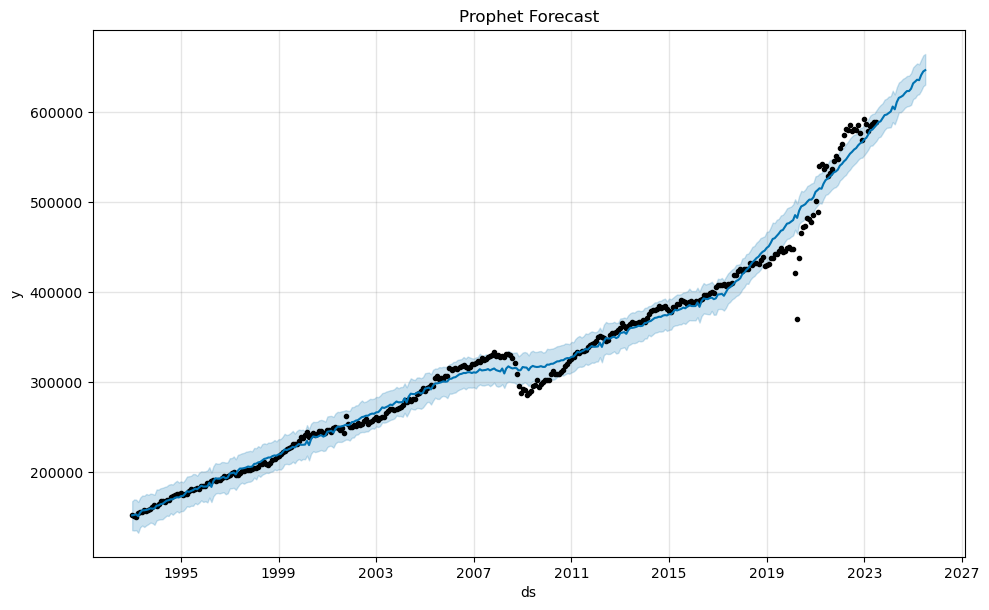

In [11]:
# Prepare data for Prophet
prophet_df = df.reset_index()[['observation_date', 'Retail Sales']]
prophet_df.columns = ['ds', 'y']  # Prophet requires these column names

# Train/test split (last 24 months as test)
train_p = prophet_df.iloc[:-24]
test_p = prophet_df.iloc[-24:]

# Initialize and fit model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(train_p)

# Forecast
future = model.make_future_dataframe(periods=24, freq='MS')
forecast = model.predict(future)

# Extract predictions for test set
y_pred = forecast.iloc[-24:]['yhat'].values
y_true = test_p['y'].values

# Evaluate
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("Prophet Performance:")
print("MAE:", mae)
print("RMSE:", rmse)

# Plot
model.plot(forecast)
plt.title("Prophet Forecast")
plt.show()
